In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.nn import BCELoss, CrossEntropyLoss
from extractor import addImagePath, textExtraction, imageExtraction, textExtractReverse

# 1. Check the max length of the text data


In [2]:
subUrlList = ['wendys','mcdonalds', 'mcdonalds_switzerland','mcdonaldscanada','sonicdrivein']
max_length = 0
sum_length = 0
for subUrl in subUrlList:
    dirPath = '../Data/Instagram/Filter_' + subUrl + '.csv'
    data = pd.read_csv(dirPath)
    
    for i in range(len(data['caption'])):
        sum_length += len(str(data['caption'][i]).split())
        if len(str(data['caption'][i]).split()) > max_length:
            max_length = len(str(data['caption'][i]).split())
            word = data['caption'][i]
print(max_length)
print(sum_length/len(data['caption']))

373
31.870794078061913


In [193]:
max_length = 0
word = ''
dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
data = pd.read_csv(dirPath)
max_length = 0
sum_length = 0
index =0 
counter  = 5
# find the max word count of the text data['caption']
for i in range(len(data['caption'])):
    sum_length += len(str(data['caption'][i]).split())
    if len(str(data['caption'][i]).split()) > max_length:
        max_length = len(str(data['caption'][i]).split())
        word = data['caption'][i]
        index = i       
        #
print(max_length, i)
print(sum_length/len(data['caption']))
data.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_5988\3251324240.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dirPath)


9729 3657846
10.514508397972905


(3657847, 3)

In [195]:
sum_length

38460463

# 2. Check the max word count of the text data

In [260]:
subUrlList = ['wendys','mcdonalds', 'mcdonalds_switzerland','mcdonaldscanada','sonicdrivein']
wordList = []
total = 0
for subUrl in subUrlList:
    dirPath = '../Data/Instagram/Filter_' + subUrl + '.csv'
    data = pd.read_csv(dirPath)
    
    for i in range(len(data['caption'])):
        for word in str(data['caption'][i]).split():
            if word not in wordList:
                wordList.append(word)
                total += 1
                
print(len(wordList))        
print(total)

15056
15056


In [261]:
wordList = []
total = 0
dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
data = pd.read_csv(dirPath)

for i in range(len(data['caption'])):
    for word in str(data['caption'][i]).split():
        if word not in wordList:
            wordList.append(word)
            total += 1

print(len(wordList))        
print(total)

C:\Users\USER\AppData\Local\Temp\ipykernel_5988\496614120.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dirPath)


KeyboardInterrupt: 

# 3. Load the data and split the data

In [2]:
# if args.img - dir == 'Oxford_HIC':
#     dirPath = '../Data/Oxford_HIC/oxford_hic_data.csv'
#     imgPath = '../Data/Oxford_HIC/oxford_img/'
# else:
dirPath = '../Data/Instagram/Filter_' + 'wendys' + '.csv'
imgPath = '../Data/Instagram/' + 'wendys' + '_img/'
# load data
data = pd.read_csv(dirPath)
data = addImagePath(data, imgPath)
# split data
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_text = textExtraction(train['caption'].tolist())
train_image = imageExtraction(train['image_id'])
train_funny_score = torch.tensor(train['funny_score'].to_numpy())
test_text = textExtraction(test['caption'])
test_image = imageExtraction(test['image_id'])
test_funny_score = torch.tensor(test['funny_score'].to_numpy())

100%|██████████| 74/74 [00:02<00:00, 32.32it/s]


In [3]:
train_text.shape, train_image.shape, train_funny_score.shape

(torch.Size([293, 64, 768]), torch.Size([293, 64, 768]), torch.Size([293]))

In [4]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(train_text, train_image, train_funny_score)
test_dataset = torch.utils.data.TensorDataset(test_text, test_image, test_funny_score)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. LLM Test

In [5]:
### 不確定是否為官方的 Gemini ############################################################################
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("describeai/gemini")
gemini = AutoModelForSeq2SeqLM.from_pretrained("describeai/gemini")
#######################################################################################################
gemini

C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [13]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",  torch_dtype=torch.bfloat16)
########################################################################################################

C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\accelerate\utils\modeling.py:1405: UserWarning: Current model requires 4608 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gemma.to(device)
vocab_size = 256128  # 词汇表大小
embedding_dim = 768  # 嵌入维度，与你的图像嵌入维度相同
text_embedding = nn.Embedding(vocab_size, embedding_dim).to(device)

words = "👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha"
tokens = tokenizer(words, truncation=True, padding= 'max_length', max_length=100, return_tensors="pt")
output = text_embedding(tokens['input_ids'].to(device))

import torch
import torch.nn.functional as F

def find_closest_embeddings(x, embedding_matrix, top_k=1):
    # Normalize both the input tensor x and the embedding matrix
    x = F.normalize(x, dim=1)  # Normalize input tensor along feature dimension
    embedding_matrix = F.normalize(embedding_matrix, dim=1)  # Normalize embedding matrix
    
    # Compute cosine similarity between x and embedding matrix
    similarity = torch.matmul(x, embedding_matrix.T)  # Shape: [10, 50265]
    
    # Find top-k closest embeddings for each tensor in x
    top_k_values, top_k_indices = torch.topk(similarity, top_k, dim=1)
    
    return top_k_indices, top_k_values


# print(output.squeeze(0).shape)
top_k_indices, top_k_values = find_closest_embeddings(output.squeeze(0), text_embedding.weight)
# top_k_indices.shape
indices = tokenizer.decode(top_k_indices.squeeze(-1))
print(indices)

torch.Size([100, 768])
<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><bos>👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha


In [171]:
words = "👻🔥😂😁👍🤦‍♀️🤦‍♂️🤷‍♀️🤷‍♂️✌🤞😉😎🎶😢💖🎉🌹💋👏🐱‍💻🐱‍🐉🐱‍👓✔👀😃✨😆🤔🤢🎁🫢 ha ha"
tokens = tokenizer(words, truncation=True, padding= 'max_length', max_length=100, return_tensors="pt")
tokens

{'input_ids': tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      2, 242538, 237638, 236471, 238429, 237019, 240525,  67292,
         240525,  68399, 239921,  67292, 239921,  68399, 239529, 241807, 238309,
         238859, 240438, 240116, 239208, 239548, 240315, 240887, 238499, 242993,
         235879, 242482, 242993, 235879, 245092, 242993, 235879, 246943, 237488,
         239220, 239938, 236309, 239312, 238918, 241769, 241227, 248165,    661,
            661]]), 'attention_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_text = "Give me three best book."
input_ids = tokenizer(input_text, return_tensors="pt").to(device)
input_ids

# outputs = gemma.generate(**input_ids, max_new_tokens=200)
# print(tokenizer.decode(outputs[0]))

C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\transformers\generation\utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on cpu. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cpu') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [127]:
gemma

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

# 4. Generator

In [5]:
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",  torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
gemma

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm()
        (post_attention_layernorm): Gemma2RMSNorm()
        (pre_feedforward_

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # self attention
        self.selfAttentionMultihead = nn.MultiheadAttention(768, 1)
        self.selfAttentionLayerNorm = nn.LayerNorm(768)
        self.selfAttentionLinear = nn.Linear(768, 768)
        self.selfAttentionLayerNorm2 = nn.LayerNorm(768)
        
        # multihead attention
        self.multiheadAttentionMultihead = nn.MultiheadAttention(768, 8)
        self.multiheadAttentionLinear = nn.Linear(768, 768)
        self.multiheadAttentionLayerNorm = nn.LayerNorm(768)
        
        # co-attention text
        self.coAttentionTextMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionTextLinear = nn.Linear(768, 768)
        self.coAttentionTextLayerNorm = nn.LayerNorm(768)

        # co-attention image
        self.coAttentionImageMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionImageLinear = nn.Linear(768, 768)
        self.coAttentionImageLayerNorm = nn.LayerNorm(768)
    
        # feed forward
        self.feedForwardLinear = nn.Linear(768, 768)
        self.feedForwardLayerNorm = nn.LayerNorm(768)
        
        # gemma
        self.gemmaLinearBefore = nn.Linear(768, 50265)
        self.gemmaSoftmax = nn.Softmax(dim=2)
        self.gemma = nn.Sequential(*list(gemma.children())[:-1])
        self.gemmaLm_head = nn.Sequential(*list(gemma.children())[1:])
        
        # funny score
        self.FunnyScorelinear1 = nn.Linear(768, 1)
        self.FunnyScorelinear2 = nn.Linear(64, 1)
        
    def gemmaGenerate(self, x):
        with torch.no_grad():
            x = self.gemmaLinearBefore(x)
            x = self.gemmaSoftmax(x)
            # get max value of each row, total 32*64
            top_k_values, top_k_indices = torch.topk(x, 1, dim=2, largest=True)
            toGemma = textExtractReverse(top_k_indices).to(device)
            
            # 使用gemma作為model的一部分
            output = self.gemma(toGemma)
            # output[0] = last_hidden_state
            # output[1] = past_key_values
            
        return output[0]
               
    
    def forward(self, text, image):
        # max_seq_len = max(text.shape[1], image.shape[1])
        # text = nn.functional.pad(text, (0, 0, 0, max_seq_len - text.shape[1]))
        # image = nn.functional.pad(image, (0, 0, 0, max_seq_len - image.shape[1]))
        text = text.transpose(0, 1)
        image = image.transpose(0, 1)
        
        ######################### Transformer ######################### 
        # self attention module
        self_out = self.selfAttentionMultihead(image, image, image)[0]
        self_out = self.selfAttentionLinear(self_out)
        self_out = self.selfAttentionLayerNorm(self_out + image)

        # multihead attention module
        multi_out = self.multiheadAttentionMultihead(text, text, text)[0]
        multi_out = self.multiheadAttentionLinear(multi_out)
        multi_out = self.multiheadAttentionLayerNorm(multi_out + text)

        # co-attention image module
        visual_attending_textual = self.coAttentionTextMultihead(self_out, multi_out, multi_out)[0]
        visual_attending_textual = self.coAttentionTextLinear(visual_attending_textual)
        visual_attending_textual = self.coAttentionTextLayerNorm(visual_attending_textual + self_out)
        
        # co-attention text module
        textual_attending_visual = self.coAttentionTextMultihead(multi_out, self_out, self_out)[0]
        textual_attending_visual = self.coAttentionTextLinear(textual_attending_visual)
        textual_attending_visual = self.coAttentionTextLayerNorm(textual_attending_visual + multi_out)
        ###############################################################
        
        # feature fusion
        feature_fusion = visual_attending_textual + textual_attending_visual
        feature_fusion = self.feedForwardLinear(feature_fusion)
        feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
        feature_fusion = feature_fusion.squeeze(-1)
        feature_fusion = feature_fusion.transpose(0, 1)
        
        ####################### gemma  generate #######################
        last_hidden_state = self.gemmaGenerate(feature_fusion)
        output_text = self.gemmaLm_head(last_hidden_state)
        ###############################################################
        
        ######################### funny score #########################
        output_funny_score = self.FunnyScorelinear1(feature_fusion).squeeze(-1)
        output_funny_score = self.FunnyScorelinear2(output_funny_score).squeeze(-1)
        ###############################################################

        return output_text, output_funny_score
    
    def generate(self, image, tokenizer, max_length=100):
        result_caption = []
        text = torch.zeros_like(image)
        
        # 有時後空格會失效，所以手動插入空格
        def insert_zeros(list):
            # <pad> = 0, <eos> = 1, <bos> = 2, <unk> = 3, <mask> = 4, <2mass> = 5, [@BOS@] = 6
            zeros = [0] * (2 * len(list) - 1)
            zeros[::2] = list
            return zeros
        
        with torch.no_grad():
            for _ in range(max_length):
                text = text.transpose(0, 1)
                image = image.transpose(0, 1)
            
                # self attention module
                self_out = self.selfAttentionMultihead(image, image, image)[0]
                self_out = self.selfAttentionLinear(self_out)
                self_out = self.selfAttentionLayerNorm(self_out + image)
                
                # multihead attention module
                multi_out = self.multiheadAttentionMultihead(text, text, text)[0]
                multi_out = self.multiheadAttentionLinear(multi_out)
                multi_out = self.multiheadAttentionLayerNorm(multi_out + text)
                        
                # co-attention image module
                visual_attending_textual = self.coAttentionTextMultihead(self_out, multi_out, multi_out)[0]
                visual_attending_textual = self.coAttentionTextLinear(visual_attending_textual)
                visual_attending_textual = self.coAttentionTextLayerNorm(visual_attending_textual + self_out)
                
                # co-attention text module
                textual_attending_visual = self.coAttentionTextMultihead(multi_out, self_out, self_out)[0]
                textual_attending_visual = self.coAttentionTextLinear(textual_attending_visual)
                textual_attending_visual = self.coAttentionTextLayerNorm(textual_attending_visual + multi_out)
                
                # feature fusion
                feature_fusion = visual_attending_textual + textual_attending_visual
                feature_fusion = self.feedForwardLinear(feature_fusion)
                feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
                feature_fusion = feature_fusion.squeeze(-1)
                feature_fusion = feature_fusion.transpose(0, 1)
                last_hidden_state = self.gemmaGenerate(feature_fusion)
                output_text = self.lm_head(last_hidden_state)
                    
                predicted = output_text.argmax(1)
                result_caption.append(predicted.item())
                
                text = insert_zeros(result_caption)
                text = tokenizer.decode(text, skip_special_tokens=False)
                text = text.replace("<pad>", " ").replace("  ", " ").split()
                text = [word for word in text if word[0] != "<"]
                text = " ".join(text)
                
                if predicted.item() == 1: #<eos> = 1
                    break
                else:
                    text = textExtraction([text])
                    # max_seq_len = max(text.shape[1], image.shape[1])
                    # text = nn.functional.pad(text, (0, 0, 0, max_seq_len - text.shape[1]))
                    # image = nn.functional.pad(image, (0, 0, 0, max_seq_len - image.shape[1]))
            
        return text

# 5. Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Generator
        self.g_linearFake1 = nn.Linear(256000, 768)
        self.g_linearFake2 = nn.Linear(256, 64)
        self.g_con_mlp1 = nn.Linear(768, 1)
        self.g_con_mlp2 = nn.Linear(128, 1)
        self.g_unc_mlp1 = nn.Linear(768, 1)
        self.g_unc_mlp2 = nn.Linear(64, 1)
        # Discriminator
        self.d_linearFake1 = nn.Linear(256000, 768)
        self.d_linearFake2 = nn.Linear(256, 64)
        self.d_con_mlp1_r = nn.Linear(768, 1)
        self.d_con_mlp2_r = nn.Linear(256, 1)
        self.d_con_mlp1_g = nn.Linear(768, 1)
        self.d_con_mlp2_g = nn.Linear(128, 1)
        self.d_con_mlp1_m = nn.Linear(768, 1)
        self.d_con_mlp2_m = nn.Linear(128, 1)
        self.d_unc_mlp1_r = nn.Linear(768, 1)
        self.d_unc_mlp2_r = nn.Linear(64, 1)
        self.d_unc_mlp1_g = nn.Linear(768, 1)
        self.d_unc_mlp2_g = nn.Linear(64, 1)
        self.d_unc_mlp1_m = nn.Linear(768, 1)
        self.d_unc_mlp2_m = nn.Linear(64, 1)
        
    def forward(self, real_text, fake_text, image):   
        # real_text = [batch_size, 64, 768]
        # fake_text = [batch_size, 256, 256000]
        # image = [batch_size, 64, 768]
        g_fake_text = self.g_linearFake1(fake_text).transpose(1, 2)
        g_fake_text = self.g_linearFake2(g_fake_text).transpose(1, 2)
        d_fake_text = self.d_linearFake1(fake_text).transpose(1, 2)
        d_fake_text = self.d_linearFake2(d_fake_text).transpose(1, 2)
        mismatched_text = torch.roll(real_text, 1, 0)
        
        # conditional (contrastive)
        C_r = torch.cat((real_text, image), dim=1)
        g_C_g = torch.cat((g_fake_text, image), dim=1)
        d_C_g = torch.cat((d_fake_text, image), dim=1)
        C_m = torch.cat((mismatched_text, image), dim=1)
        # contrastive discriminator
        d_C_r = torch.cat((C_r, d_C_g), dim=1)
        
        ########################## Generator ##########################
        g_C_g = self.g_con_mlp1(g_C_g).squeeze(-1)
        g_C_g = self.g_con_mlp2(g_C_g).squeeze(-1).unsqueeze(0) #(32x320 and 128x1)
        ###############################################################
        
        ######################## Discriminator ########################
        d_C_r = self.d_con_mlp1_r(d_C_r).squeeze(-1)
        d_C_g = self.d_con_mlp1_g(d_C_g).squeeze(-1)
        d_C_m = self.d_con_mlp1_m(C_m).squeeze(-1)
        d_C_r = self.d_con_mlp2_r(d_C_r).squeeze(-1).unsqueeze(0)
        d_C_g = self.d_con_mlp2_g(d_C_g).squeeze(-1).unsqueeze(0)
        d_C_m = self.d_con_mlp2_m(d_C_m).squeeze(-1).unsqueeze(0)
        d_con_output = torch.cat((d_C_r, d_C_g, d_C_m), dim=0)
        ###############################################################
        
        
        #### unconditional ####
        ########################## Generator ##########################
        g_UC_g = self.g_unc_mlp1(g_fake_text).squeeze(-1)
        g_UC_g = self.g_unc_mlp2(g_UC_g).squeeze(-1).unsqueeze(0)
        g_output = torch.cat((g_C_g, g_UC_g), dim=0)
        ###############################################################
        
        ######################## Discriminator ########################
        d_UC_r  = self.d_unc_mlp1_r(real_text).squeeze(-1)
        d_UC_g  = self.d_unc_mlp1_g(d_fake_text).squeeze(-1)
        d_UC_m  = self.d_unc_mlp1_m(mismatched_text).squeeze(-1)
        d_UC_r = self.d_unc_mlp2_r(d_UC_r).squeeze(-1).unsqueeze(0)
        d_UC_g = self.d_unc_mlp2_g(d_UC_g).squeeze(-1).unsqueeze(0)
        d_UC_m = self.d_unc_mlp2_m(d_UC_m).squeeze(-1).unsqueeze(0)
        d_unc_output = torch.cat((d_UC_r, d_UC_g, d_UC_m), dim=0)
        ###############################################################

        # torch.Size([3, 32, 1])
        return g_output, d_con_output, d_unc_output

In [19]:
# empty cuda memory
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
report_gpu()
torch.cuda.empty_cache()
gc.collect()

pynvml module not found, please install pynvml


0

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NetG = Generator().to(device)
NetD = Discriminator().to(device)
optimizer_G = optim.Adam(NetG.parameters(), lr=0.001)
optimizer_D = optim.Adam(NetD.parameters(), lr=0.001)
funnyScoreLoss = nn.MSELoss()

def generatorLoss(generator_logits):
    m = nn.Sigmoid()
    result_fake = (torch.zeros(generator_logits[1].shape[0])).to(device)
    unc_loss = BCELoss()(m(generator_logits[1]), result_fake)
    con_loss = BCELoss()(m(generator_logits[0]), result_fake)
    loss = con_loss + unc_loss
    return loss

def discriminatorLoss(uncondition_logits, condition_logits):
    m = nn.Sigmoid()
    result_true = (torch.ones(condition_logits[0].shape[0])).to(device)
    result_fake = (torch.zeros(condition_logits[0].shape[0])).to(device)
    unc_r = BCELoss()(m(condition_logits[0]), result_true)
    unc_f = BCELoss()(m(condition_logits[1]), result_fake)
    unc_m = BCELoss()(m(condition_logits[2]), result_fake)
    con_r = CrossEntropyLoss()(uncondition_logits[0], result_true)
    con_f = CrossEntropyLoss()(uncondition_logits[1], result_fake)
    con_m = CrossEntropyLoss()(uncondition_logits[2], result_fake)
    loss = unc_r + ((unc_f + unc_m)/2) + con_r + ((con_f + con_m)/2)
    return loss

train_losses_FC = []
train_losses_G = []
train_losses_D = []
test_losses_FC = []
test_losses_G = []
test_losses_D = []

In [21]:
epochs = 10
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    print("---------------------------------- epoch "+ str(epoch) +" ----------------------------------")
    train_loss_FC = 0
    train_loss_G = 0
    train_loss_D = 0
    test_loss_FC = 0
    test_loss_G = 0
    test_loss_D = 0
    
    ###################################### Train ######################################
    with tqdm(train_loader, unit="batch") as tepoch:
        for text, image, funny_score in tepoch:
            ######################################################
                # (1) Generate fake caption
            ######################################################
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            gen_logits, con_logits, unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            ######################################################
                # (3) Update Discriminator network
            #####################################################
            optimizer_D.zero_grad()
            loss_D = discriminatorLoss(unc_logits, con_logits)
            loss_D.backward(retain_graph=True)
            optimizer_D.step()
            train_loss_D += loss_D.item()
            ######################################################
                # (4) Update Generator network
            ######################################################
            optimizer_G.zero_grad()
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_FC.backward(retain_graph=True)
            train_loss_FC += loss_FC.item()
            loss_G = generatorLoss(gen_logits)
            loss_G.backward()
            optimizer_G.step()
            train_loss_G += loss_G.item()
            ######################################################
            # postfix = str(train_loss_G) + ' / ' + str(train_loss_D)
            tepoch.set_postfix({'FC_loss': train_loss_FC, 'G_loss': train_loss_G, 'D_loss': train_loss_D})
    train_losses_FC.append(train_loss_FC)
    train_losses_G.append(train_loss_G)
    train_losses_D.append(train_loss_D)
    ###################################### Train ######################################
    
    
    ######################################  Test ######################################
    with tqdm(test_loader, unit="batch") as tepoch:
        for text, image, funny_score in tepoch:
            # Generator
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            # Discriminator
            gen_logits, con_logits, unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            # loss
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_G = generatorLoss(gen_logits)
            loss_D = discriminatorLoss(unc_logits, con_logits)
            test_loss_FC += loss_FC.item()
            test_loss_G += loss_G.item()
            test_loss_D += loss_D.item()
            tepoch.set_postfix({'FC_loss': test_loss_FC, 'G_loss': test_loss_G, 'D_loss': test_loss_D})
    test_losses_FC.append(test_loss_FC)
    test_losses_G.append(test_loss_G)
    test_losses_D.append(test_loss_D)
    ######################################  Test ######################################


---------------------------------- epoch 0 ----------------------------------


  0%|          | 0/10 [00:14<?, ?batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.81 GiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 28.27 GiB is allocated by PyTorch, and 2.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

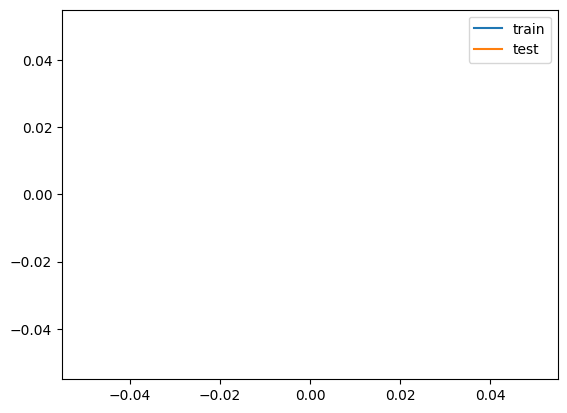

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_losses_G, label='train')
plt.plot(test_losses_G, label='test')
plt.legend()
plt.show()


# Generate Test

In [302]:
A = [0,155,2,355,4,544,6,788,8,944,10]
def insert_zeros(list):
    # <pad> = 0, <eos> = 1, <bos> = 2, <unk> = 3, <mask> = 4, <2mass> = 5, [@BOS@] = 6
    zeros = [0] * (2 * len(list) - 1)
    zeros[::2] = list
    return zeros

A = insert_zeros(A) 
print(A)
text = tokenizer.decode(A, skip_special_tokens=False)
text = text.replace("<pad>", " ").replace("  ", " ").split()
text = [word for word in text if word[0] != "<"]
text = " ".join(text)
text = textExtraction([text])
print(text.shape)


[0, 0, 155, 0, 2, 0, 355, 0, 4, 0, 544, 0, 6, 0, 788, 0, 8, 0, 944, 0, 10]


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

torch.Size([1, 373, 768])
